# Example :  Language Modeling
https://www.kaggle.com/code/prashant111/comprehensive-guide-to-rnn-with-keras/notebook#4.Implementation-of-SimpleRNN-with-Keras---text-generation-

In this example we apply the SimpleRNN for the language modeling task.

In the end we will see also some improvements.

### Language modeling
Language modeling consists in, given a sequence of tokens (e.g. characters or words), returning the most probable token for continuing that sequence.

For example, given the english words "I like pizza a lot, my" a language model could return as next word the word "favourite".

More formally, a language model takes in input a sequence of tokens and returns a probability distribution over all the possible tokens: in this way, we can compute the most probable next token.

### Specific example
In this example, build a language model on the "Alice in the Wonderland" book, for learning to generate sentences in the style of the book. We build a character-based language model: given a sequence of characters, we predict the next character.

Of course, a character-based language model is quite limited. It would be better a word-based language model.

In particular, we make a language model which takes in input a sequence of $N=10$ characters, and it predicts the next character. So, our model takes in input a sequence of length $N=10$.

In [49]:
N=10

## DATASET
The dataset is available in the "wonderland.txt" file. It is the "Alice in the wonderland" book.

In [50]:
import numpy as np 
import pandas as pd 
import os

In [51]:
INPUT_FILE = "wonderland.txt"

### Loading
We load the dataset. Since we want to build a character-based language model, we load the dataset as a list of characters.

In [52]:
text_file = open(INPUT_FILE, 'rb')

In [53]:
# List, which will contain all the lines of the book. Each line is stored as a string
lines = []
for line in text_file:
    # Removing trailing characters
    line = line.strip()
    # We transform all the characters to lowercase
    line = line.lower()
    line = line.decode("ascii", "ignore")
    # We skip empty lines
    if len(line) == 0:
        continue
    lines.append(line)
text_file.close()

In [54]:
# Out data is a single string
text = " ".join(lines)

In [55]:
print('First character:', text[0])
print('Second character:', text[1])

First character: p
Second character: r


## PREPROCESSING
For now, our dataset is a set of characters. But this is not compliant with NNs: we want numbers. We have to do some preprocessing.

### Mapping characters into numbers
First of all, we map characters into numbers. We create a biunivocal correspondance between characters and numbers.

In [56]:
# Set of all the possible characters in our dataset
chars = set([c for c in text])

# Number of all the possible characters
n_chars = len(chars)
n_chars

55

In [57]:
# Dictionary, which maps characters into the corresponding integers (i.e. indeces) 
char2index = dict((c, i) for i, c in enumerate(chars))

# Dictionary, which maps integers/indeces into the corresponding characters 
index2char = dict((i, c) for i, c in enumerate(chars))

### Creating the inputs and the targets
Since now, our dataset is simply a single list of characters. We want to create our inputs and our targets.

An input $x$ is a sequence of $N=10$ adjacent characters. The corresponding target $y$ is the next character of that sequence.

So, given our text, we divide into all the possible instances $x$, which are all the possible sequences of $N=10$ adjacent characters. And, then, we associate to each instance $x$ the corresponding target $y$, which is the next character.

In [58]:
# List which will contain all the possible instances x, which are all the possible sequences of N adjacent characters
inputs = []

# List which will contain the targets for the corresponding instances x
targets = []

# We iterate over all the possible characters in the text
# Actually, we don't consider the last N characters
for i in range(0, len(text)-N):
  # Instance x: it consists in the N consecutive characters starting from the index 'i'
  x = text[i : i+N]
  inputs.append(x)

  # Target corresponding to the instance x: it is the character after N characters. It is the character rigth after the sequence
  y = text[i+N]
  targets.append(y)

We call $M$ the number of input instances $x$. Which is the same number of the targets $y$.

In [59]:
M = len(inputs)
M

158773

### One-hot encoding
The final step is to one-hot encode our characters.

Since now, each character is represented as a number. We want to change that. We want to represent a character as a vector, with length `n_chars`. So, there is a value for each possible character in our text. At each position on this vector, there is a corresponding character, which is determined by the mapping created before. So, biunivocal mapping between the indeces of this vector and all the possible characters in our text. 

So, given a character $c$, with corresponding integer $j$, we represent it as a vector of length `n_chars`. In each index $i$ we place: $0$ if that index/character $i$ is not $c$; $1$ if that index/character $i$ is $c$. basically, we put a $0$ if $i \neq j$, $1$ otherwise.

To sum up, we represent each character $c$ with a vector with only $0$ except in the position corresponding to that character, where there is a $1$.

This is called one-hot encoding.

So, we build our tensor $X$, which will contain the input instances $x$. Each input instance $x$ is a sequence of $N$ characters, where each character is represented as a vector of $n_{chars}$ values. The dimensions of $X$ are $M*N*n_{chars}$, since there are $M$ input instances $x$, each of them is a sequence of $N$ characters, and each characters is a vector of $n_{chars}$ values. 

We also build the tensor $Y$, which will contain the targets $y$. Dimensions $M*n_{chars}$, since there are $M$ targets, each of them consisting in a single char, which is a vector of $n_{chars}$ values.

The values in the tensors $X$ and $Y$ are simply $0/1$. Which can be seen as booleans.

In [12]:
# Initializing X and Y, to all 0
X = np.zeros((M, N, n_chars), dtype=bool)
Y = np.zeros((M, n_chars), dtype=bool)

In [13]:
# Populating X and Y

# We iterate over all instances x: each x is a sequence of N characters
for i, x in enumerate(inputs):

  # We iterate over all characters in x
  for j, ch in enumerate(x):
    # We place 1 in the position corresponding to that character
    X[i, j, char2index[ch]] = 1

  # We place 1 to the character corresponding to the target character  
  Y[i, char2index[targets[i]]] = 1

Let's inspect an instance $x$

In [14]:
# Instance x: it is a sequence of N=10 characters, where each character is a vector of n_chars=55 values
x = X[0]
print(x.shape)

(10, 55)


Let's inspect a character $c$ in $x$

In [15]:
# Character c: it is a boolean vector of n_dims=55 values
c = x[0]
print(c.shape)
print(c)

(55,)
[False False False False False False False False False False False False
 False False False False False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False]


Let's inspect a target y

In [16]:
# Target y: it's a character, i.e. a vector of n_dims=55 values
y = Y[0]
print(y.shape)
y

(55,)


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False])

### Meaning of the one-hot encoding targets: true categorical distribution
We have our targets in $Y$. Each target $y$ is a vector of $n_{chars}$ values, with all $0$ except in the position corresponding to that character.

Basically, this vector is the true categorical distribution of that character. It is the actual categorical distribution.

This kind of representation is convenient to have, since we our language model returns a vector $\hat{y}$ which is a probability distribution over the $n_{chars}$ possible characters: comparing $y$ and $\hat{y}$ can be done with the classic categorical crossentropy.

## RNN
Our network consists in a SimpleNN and a Dense layer.

### Inputs
Each input element $X_t$ is a character. So, vector with $n_{chars}$ values.

An input $x$ is a sequence of $N$ characters. Sequence $X_1, ..., X_N$.

Therefore, the number of time steps is $N$. Each time step is a different character in the sequence.

### Output
Given the input sequence $X_1,...,X_N$, the RNN returns $N$ outputs $h_1, ..., h_N$.

Each output $h_t$ represents the prediction of the next character in the sequence, which is the $(t+1)$-th character (i.e. $X_{t+1})$. The output $h_t$ represents the prediction made by the RNN given the inputs $X_1,...,X_{t}$: so, $h_t$ is the predicted next character $\hat{X}_{t+1}$ in the sequence (prediction of the $(t+1)$ character).

More precisely, $h_t$ is a probability distribution over all the possible characters. Which allows us to select the next character in the sequence: the predicted $(t+1)$-th character (i.e. $\hat{X}_{t+1}$) is the character which has the biggest probability in the vector $h_t$.

This means that each output $h_t$ is a vector of $n_{chars}$ values, representing a probability distribution over all the possible characters. Probability distribution for the next character $\hat{X}_{t+1}$.

Given the input sequence $X_1,...,X_N$, the RNN returns $N$ outputs $h_1, ..., h_N$. However, we are interested only in the last output $h_N$, because we want only to predict the next character right after the sequence: character $X_{N+1}$ (the prediction is $\hat{X}_{N+1}$)

### Precisation about the output
Actually, it is not true that each output $h_t$ represents the probability distribution for $\hat{X}_{t+1}$. $h_t$ is not a probability distribution.

Actually, $h_t$ is a vector of $O$ values. The purpose of this vector is to be used by a Dense layer for building the probability distribution for $\hat{X}_{t+1}$: we call this probability distribution $Y_{t}$.

So:
- Each output element $h_t$ is not a vector of length $n_{chars}$, but a vector of $O$ values. We fix $O=128$. Instead, the final prediction $Y_t$ is a vector of length $n_{chars}$.
- Each output element $h_t$ is not directly our probability distribution for the next character $X_{t+1}$, but it is used by a Dense layer for making that probability distribution $Y_t$. From an high level point of view, we can consider $h_t$ as the probability distribution for the next character $X_{t+1}$.

This means that, given a input sequence $X_1, ..., X_N$, we consider only the last output $h_N$ of the RNN, which is a vector with $O=128$ values. We pass that to a Dense layer for making the probability distribution for the next character $X_{N+1}$, which is $Y_N$: a vector of $n_{chars}$ values.

### Dense layer
The dense layer has $n_{chars}$ outputs. Softmax activation function, since we want produce a probability distribution.

### Defining the network
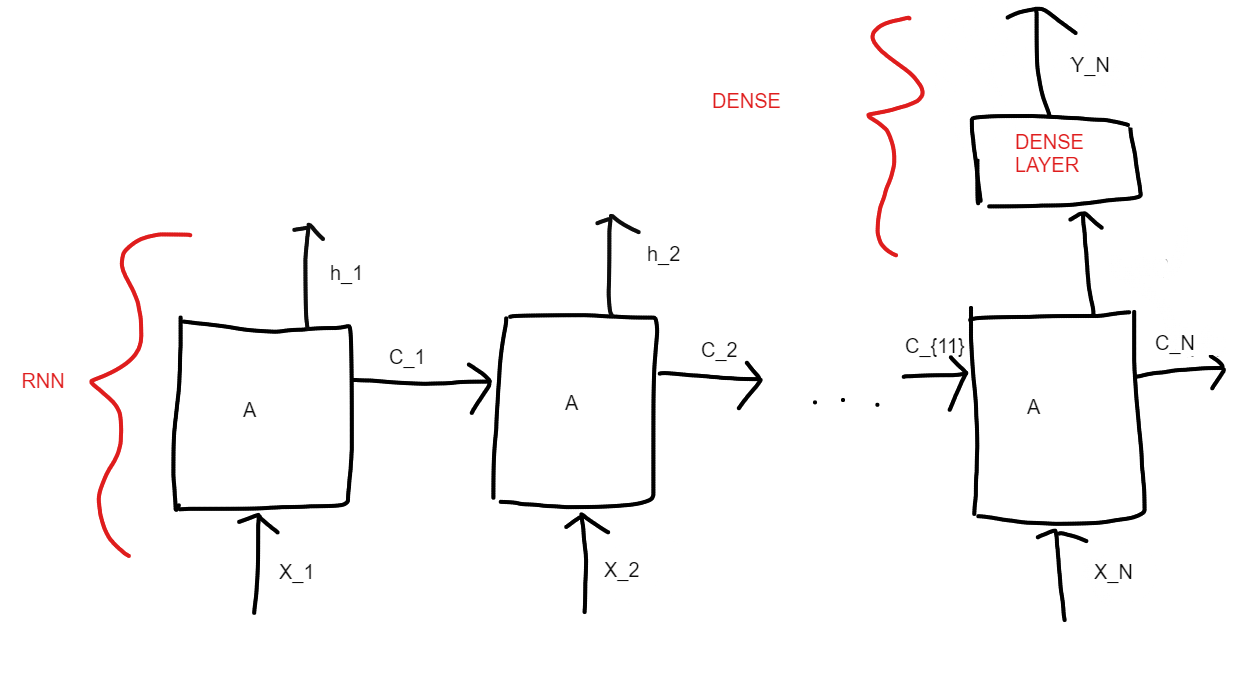

Input sample, which is a sequence $X_1, ..., X_N$, representing $N$ consecutive characters. The final output is $Y_N$, which is the probability distribution over all the possible characters for predicting the next character $\hat{X}_{N+1}$.

In [17]:
from tensorflow.keras.layers import Input, SimpleRNN, Dense 
from tensorflow.keras import Model

In [18]:
# Size of each output h_t
O = 128

In [19]:
# Input x: sequence of N characters, where each character is a vector of length n_chars
x = Input(shape=(N,n_chars))

# RNN: we keep only the last output h_N, which is a vector with $O$ values
last_h = SimpleRNN(units=O)(x)

# Dense layer: it takes in input h_n, and it produces y_hat, which is the categorical distribution over all the possible characters
y_hat = Dense(units=n_chars, activation='softmax')(last_h)

rnn = Model(inputs=x, outputs=y_hat)

In [20]:
rnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 55)]          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               23552     
                                                                 
 dense (Dense)               (None, 55)                7095      
                                                                 
Total params: 30,647
Trainable params: 30,647
Non-trainable params: 0
_________________________________________________________________


### Compile

We use rmsprop as optimizer.

As loss function, we use the categorical crossentropy. For each input instance $x$, the NN produces the output $\hat{y}$, which is a categorical distribution over the $n_{chars}$ possible characters. The ground truth is $y$, which is the one-hot encoded true character: length $n_{chars}$, all $0$, except in the True characters. Basically, $\hat{y}$ is the predicted categorical distribution, $y$ is the true categorical distribution: we can measure the distance between the two using the classic categorical crossentropy.

In [21]:
rnn.compile(loss="categorical_crossentropy", optimizer="rmsprop")

### Training

In [ ]:
rnn.fit(X, Y, batch_size=128, epochs=25)

Epoch 1/25
1241/1241 [==============================] - 18s 13ms/step - loss: 2.3407
Epoch 2/25
1241/1241 [==============================] - 16s 13ms/step - loss: 2.0445
Epoch 3/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.9422
Epoch 4/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.8641
Epoch 5/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.7993
Epoch 6/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.7447
Epoch 7/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.6984
Epoch 8/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.6584
Epoch 9/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.6252
Epoch 10/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.5968
Epoch 11/25
1241/1241 [==============================] - 16s 13ms/step - loss: 1.5718
Epoch 12/25
1241/1241 [==============================] - 16s 13

## APPLICATION OF THE NETWORK
Let's apply the network for generating some text.

We define a function which takes in input:
- an initial sequence of characters $s$, which must have length $N=10$
- a number $K$, which is the number of characters that we want to generate.

Basically, the aim is to generate the $K$ next characters after the given sequence $s$.

For doing so, the NN is applied $K$ times, with a sliding window approach.
1. At the beginning, it is applied on the given $N=10$ characters, i.e. $s$. We produce the next character $c_{N+1}$.
2. Then, we apply the NN on the sequence of $N=10$ characters composed of the last $N-1$ characters of $s$ (we get rid of the first character) and the just generated character $c_{N+1}$. We produce the next character $c_{N+2}$.
3. Then, we apply the NN on the sequence of $N=10$ characters composed of the last $N-2$ characters of $s$ (we get rid of the first two characters) and the new two characters $c_{N+1},c_{N+2}$. We produce the next character $c_{N+3}$.

...

And so on

In [26]:
def process(s):
  """ Transform the given string into the corresponding one-hot encoded matrix x.

  Basically, s is a string of n characters. The corresponding one-hot encoded instance x is a sequence of n characetrs, where each
  character is a vector of n_chars values.
  
  """
  n = len(s)
  x = np.zeros((n, n_chars)) 
  for i,c in enumerate(s):
    idx = char2index[c]
    x[i, idx] = 1
  return x

In [27]:
def generate_text(s, K):
  """ Generate K new charactes after the given string s. s must have length N """

  for i in range(K):
    # We process the string s into an instance x, which is a sequence of one-hot encoded characters: shape of x is N*n_chars
    x = process(s)
    # We add the batch dimension into x, since our NN processes only batches. The shape of x_batch is 1*N*n_chars
    x_batch = np.expand_dims(x, 0)

    # We apply the NN, and we get the predicted categorical distribution for the next character. Actually, we get a batch
    y_hat_batch = rnn.predict(x_batch)
    # We extract the categorical distribution from the batch
    y_hat = y_hat_batch[0]

    # Predicted character, corresponding to the character with higher probabiliry
    c_hat = index2char[np.argmax(y_hat)]
    # We print that
    print(c_hat, end="")

    # We update our string of N characters, by removing the first one, and by appending the new one
    s = s[1:] + c_hat

In [31]:
s = 'alice said'
generate_text(s, K=100)

 the king and the project gutenberg literary are more the project gutenberg literary are more the pr

In [ ]:
s = 'alice said'
generate_text(s, K=300)

 to herself, and she was going to the to this to like the long and which the some of the words and she was going to the to this to like the long and which the some of the words and she was going to the to this to like the long and which the some of the words and she was going to the to this to like 

In [ ]:
s = 'cheshire c'
generate_text(s, K=300)

ould be to the things and she was going to the to this to like the long and which the some of the words and she was going to the to this to like the long and which the some of the words and she was going to the to this to like the

## IMPROVEMENTS

Let's see some improvements. Inspiration from  https://www.tensorflow.org/text/tutorials/text_generation#generate_text

### First improvement: embedding
Since now we have used the one-hot encoding of the characters. A better way of dealing with characters could be to use embeddings. An embedding maps a character (represented as an integer id) into a vector of integers, with a certain fixed dimension (i.e. `embedding_dim`). In this way, we are able to represent characters as vectors of integers.

*Also the one-hot encoding represents characters as vectors, but they are very sparse vectors. Only one $1$. Instead, now we represent charachters as proper integer vectors.*

This embedding is learnt. It has parameters. An alternative could be to use a pre-trained embedding.

From an high level point of view, our model takes in input a sequence of characters, represented as integer ids, and returns a categorical distribution over all possible characters, where the characters are represented as integer ids.

For this purpose, we transform the `inputs` (which since now contain characters) in such a way they contain integer ids.

In [18]:
inputs[0]

'project gu'

In [60]:
inputs_ids = [[char2index[c] for c in s] for s in inputs]
inputs_ids = np.array(inputs_ids)

In [61]:
inputs_ids.shape

(158773, 10)

Let's do the same for the `targets`.

In [62]:
targets[0]

't'

In [63]:
targets_ids = np.array([char2index[c] for c in targets])

In [64]:
targets_ids.shape

(158773,)

### Second improvement: model sequence length
We have defined our model in order to take in input a sequence of $N$ characters. This is good for training, but it is limitating for the generation phase, since we are forced to start from a sequence with $N$ characters. 

We can solve this by simply defining our model with an unspecified sequence length: `None`. In this way, the model can take in input a sequence with any length.

### Third improvement: text generation
We have seen a basic way for generating text. Namely, we took the last $N$ characters and we gave them to the model, for generating the next character. We repeat that in a loop, in auto-regressive fashion. The following image shows how the generation of the text "alice in the wonderland" works. 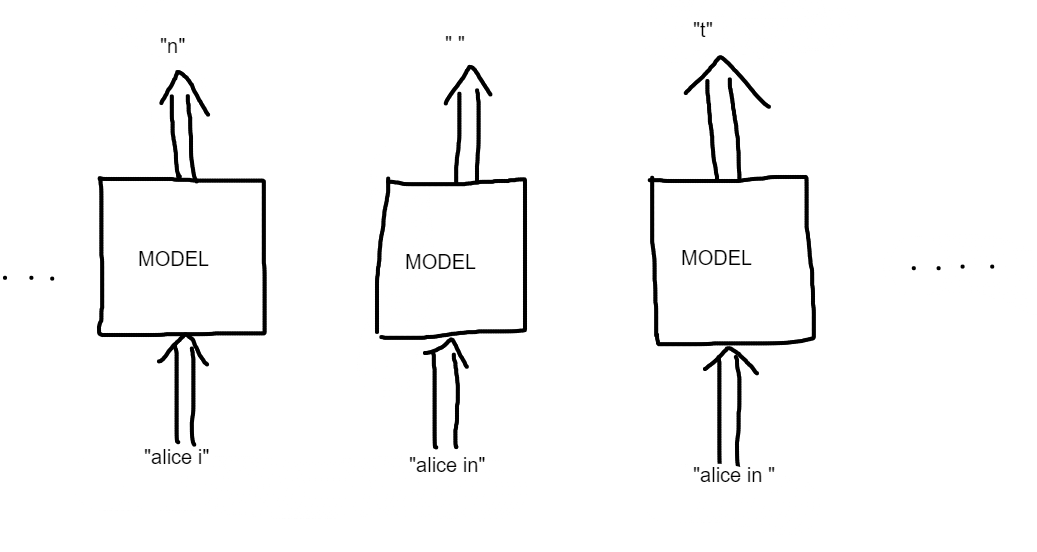



This works and it is easy to understand, but it is inefficient. It performs several times the same computation inside the model, because we give to it also the same characters produced before. The RNN units (i.e. units A) inside the model have to perform the same computations again and again. 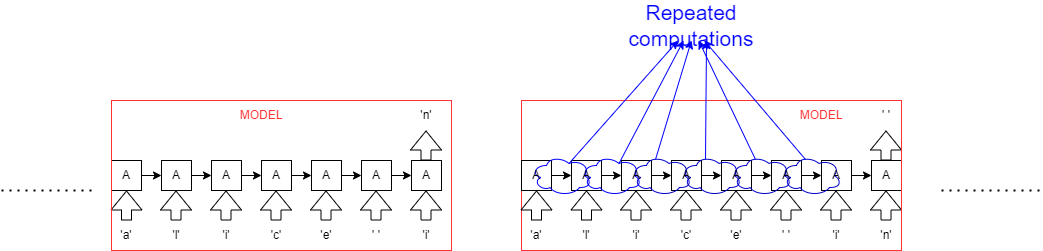

A more efficient way of generating text would be the following. 

First of all,  we define our model such that it can optionally take in input also the initial states for the first RNN unit. 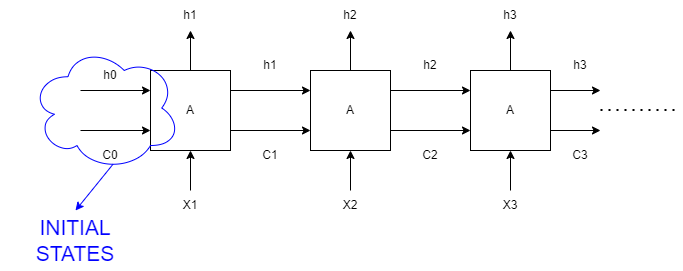

Then, the generation of the characters consists in giving to the model only the last generated character, instead of giving all the previous characters. At each step, we give to the model the last generated character.

Actually, we have to give to the model also the states returned from the character generation.

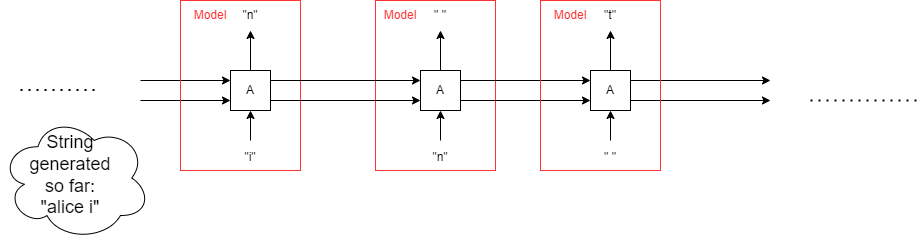

This is exactly equivalent to the generation done before. But we avoid a lot of repeated and useless computation.

From an high level point of view, the situation is the following. 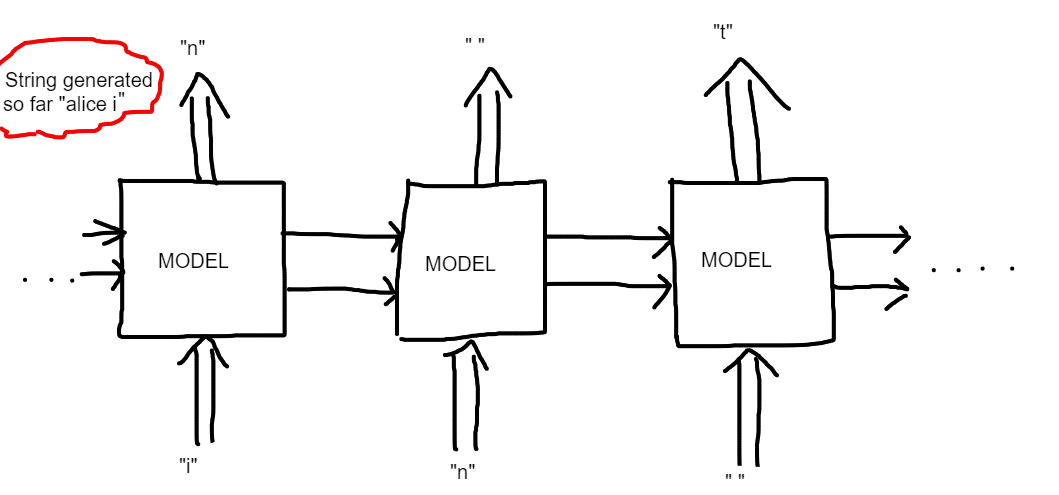

### Fourth improvement: LSTM
We use LSTM instead of simple RNN.

### Defining the model
Let's implement these improvements.

In [65]:
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras import Model

In [66]:
# Dimension of the embedding
embedding_dim = 100

# Size of each output h_t
O = 128

In [67]:
# Input x: sequence of T characters, where each character is an integer id.
# The number of characters (i.e. T) is undefined.
xin = Input(shape=(None,))

x = Embedding(n_chars, embedding_dim)(xin)

# LSTM: we keep only the last output h_T, which is a vector with $O$ values
last_h = LSTM(units=O)(x)

# Dense layer: it takes in input h_T, and it produces y_hat, which is the categorical distribution over all the possible characters
y_hat = Dense(units=n_chars)(last_h)  # No activation, beacuse we use sparse categorical crossentropy

model = Model(inputs=xin, outputs=y_hat)

In [68]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_5 (Embedding)     (None, None, 100)         5500      
                                                                 
 lstm_5 (LSTM)               (None, 128)               117248    
                                                                 
 dense_5 (Dense)             (None, 55)                7095      
                                                                 
Total params: 129,843
Trainable params: 129,843
Non-trainable params: 0
_________________________________________________________________


### Better definition of the model
We define the model in abetter way, such that it is easier the generation phase. Indeed, for generating text, we need to pass the initial states and to get the new states.

In [96]:
class MyModel(Model):
  def __init__(self, n_chars, embedding_dim, O):
    super().__init__(self)
    self.embedding = Embedding(n_chars, embedding_dim)
    self.lstm = LSTM(units=O, return_state=True)
    self.dense = Dense(units=n_chars)

  def call(self, xin, initial_states=None, return_states=False, training=False):
    x = self.embedding(xin, training=training)
    if initial_states is None:
      initial_states = self.lstm.get_initial_state(x)
    h_last, h_last, c_last = self.lstm(x, initial_state=initial_states, training=training)
    y = self.dense(h_last, training=training)

    states = (h_last, c_last)

    if return_states:
      return y, states
    else:
      return y

In [97]:
model = MyModel(n_chars, embedding_dim, O)

### Compile

We use rmsprop as optimizer.

As loss function, we use the sparse categorical crossentropy, from logits. 

In [98]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [99]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer="rmsprop")

### Training

In [100]:
model.fit(inputs_ids, targets_ids, batch_size=128, epochs=30)

Epoch 1/30
1241/1241 [==============================] - 7s 4ms/step - loss: 2.2960
Epoch 2/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.8393
Epoch 3/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.6512
Epoch 4/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.5356
Epoch 5/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.4562
Epoch 6/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.3973
Epoch 7/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.3503
Epoch 8/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.3126
Epoch 9/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.2811
Epoch 10/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.2535
Epoch 11/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.2285
Epoch 12/30
1241/1241 [==============================] - 5s 4ms/step - loss: 1.2065
E

### Generation of the text


In [107]:
def generate_text(s, K):
  """ Generate K new charactes after the given string s. 
  
  s must have at least one character. K must be at least 1. """

  # 1) For generating the first new character, we use the whole string `s`

  # Vector of integer ids, corresponding to the chars
  x = np.array([char2index[c] for c in s])
  # We add the batch dimension into x, since our NN processes only batches
  x_batch = np.expand_dims(x, 0)

  # We apply the NN, and we get the predicted categorical distribution for the next character. We get also the states
  y_hat_batch, states = model(xin=x_batch, return_states=True)
  # We extract the categorical distribution from the batch
  y_hat = y_hat_batch[0]

  # Predicted character, corresponding to the character with higher probabiliry
  c_hat = index2char[np.argmax(y_hat)]
  # We print that
  print(c_hat, end="")

  # Last generated character
  last_char = c_hat

  # 2) Now we generate the remaining characters

  for i in range(K-1):
    # Integer id corresponding to the char
    x = np.array([char2index[last_char]])
    # We add the batch dimension into x, since our NN processes only batches
    x_batch = np.expand_dims(x, 0)

    # We apply the NN, and we get the predicted categorical distribution for the next character and the new states
    y_hat_batch, states = model(xin=x_batch, initial_states=states, return_states=True, training=False)
    # We extract the categorical distribution from the batch
    y_hat = y_hat_batch[0]

    # Predicted character, corresponding to the character with higher probabiliry
    c_hat = index2char[np.argmax(y_hat)]
    # We print that
    print(c_hat, end="")

    # We update our string of N characters, by removing the first one, and by appending the new one
    last_char = c_hat

In [114]:
s = 'ali'
generate_text(s, K=100)

ce thought, i dont that she was still it had chryec, said the grass of the mock turn in a sort of th

In [119]:
s = 'the '
generate_text(s, K=300)

was a little sider and sentence at the courts. im this elect hand, and she could not like you would not seem to a minute of the mean the work in a solemn to-- if important to the misters of the end of hers forther shart in at once, with a little begance of her hatters why said in a suruord as she sa

In [116]:
s = 'queen'
generate_text(s, K=300)

 of thing the mouse of its first had began down on the sea is the mett the duchess. why seemed to herself to leave had choserapped not the mock turn into the march happe and great dealch one of the same as she said, the mouse had not a pig, and seemed to any more this work.  you may be so earrop of 